## Baseline model 

As a baseline model we will use ResNet 18, first with its pre-trained weights

---

# Adapted

Source: https://www.pluralsight.com/resources/blog/guides/introduction-to-resnet

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data preprocessing

In [50]:
labels = pd.read_csv('selected_labels.csv')
labels = labels.drop(columns=['Ball', 'Gate', 'referee Image'])


In [51]:
LABELS = [
    'Start/Restar the game',
    'The joy of the players',
    'yellow card',
    'Red Card',
    'Stadium View',
    'Penalty Image',
    'Free Kick',
    'Generic Moment'
]

In [52]:
# visualize the mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(LABELS)}
label_to_index

{'Start/Restar the game': 0,
 'The joy of the players': 1,
 'yellow card': 2,
 'Red Card': 3,
 'Stadium View': 4,
 'Penalty Image': 5,
 'Free Kick': 6,
 'Generic Moment': 7}

In [53]:
labels['label'] = labels[LABELS].idxmax(axis=1).map({label: idx for idx, label in enumerate(LABELS)})
labels['label'] = labels['label'].astype(int)


In [54]:
labels['label'].value_counts()

label
4    3209
6    2020
7    1387
1    1329
2     586
5     452
0     326
3      70
Name: count, dtype: int64

In [55]:
labels = labels.drop(columns=LABELS)

In [56]:
# ==== Config ====
batch_size = 32
learning_rate = 1e-3
num_epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



In [57]:
# ==== Custom Dataset ====
class MatchDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, str(row['Image Number']) + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = row['label']

        if self.transform:
            image = self.transform(image)
        return image, label


In [58]:
# ==== Transforms ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# ==== Load Data ====
image_path = 'data/selected_images'
dataset = MatchDataset(labels, image_path, transform)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [59]:
# ==== Model ====
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(LABELS))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martinaserandrei/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
# ==== Training Loop ====
train_acc, val_acc, train_loss, val_loss = [], [], [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total * 100
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = val_correct / val_total * 100
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"[{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'resnet18_football_best.pth')
        print("✅ Saved new best model.")

print("Training complete.")

[1/100] Train Loss: 0.8244, Acc: 72.46%, Val Loss: 0.6344, Acc: 78.89%
✅ Saved new best model.
[2/100] Train Loss: 0.5652, Acc: 81.03%, Val Loss: 0.5408, Acc: 82.14%
✅ Saved new best model.
[3/100] Train Loss: 0.4272, Acc: 85.37%, Val Loss: 0.5124, Acc: 82.20%
✅ Saved new best model.
[4/100] Train Loss: 0.3556, Acc: 87.75%, Val Loss: 0.5825, Acc: 80.92%
[5/100] Train Loss: 0.2771, Acc: 90.38%, Val Loss: 0.5119, Acc: 83.64%
✅ Saved new best model.
[6/100] Train Loss: 0.2424, Acc: 91.86%, Val Loss: 0.5854, Acc: 83.00%
[7/100] Train Loss: 0.1696, Acc: 94.14%, Val Loss: 0.5782, Acc: 83.80%
[8/100] Train Loss: 0.1344, Acc: 95.43%, Val Loss: 0.8642, Acc: 79.53%
[9/100] Train Loss: 0.1300, Acc: 95.60%, Val Loss: 0.5899, Acc: 83.80%
[10/100] Train Loss: 0.1098, Acc: 96.33%, Val Loss: 0.6521, Acc: 84.65%
[11/100] Train Loss: 0.0894, Acc: 97.11%, Val Loss: 0.5722, Acc: 87.10%
[12/100] Train Loss: 0.0494, Acc: 98.29%, Val Loss: 0.7327, Acc: 83.00%
[13/100] Train Loss: 0.0861, Acc: 97.23%, Val Los

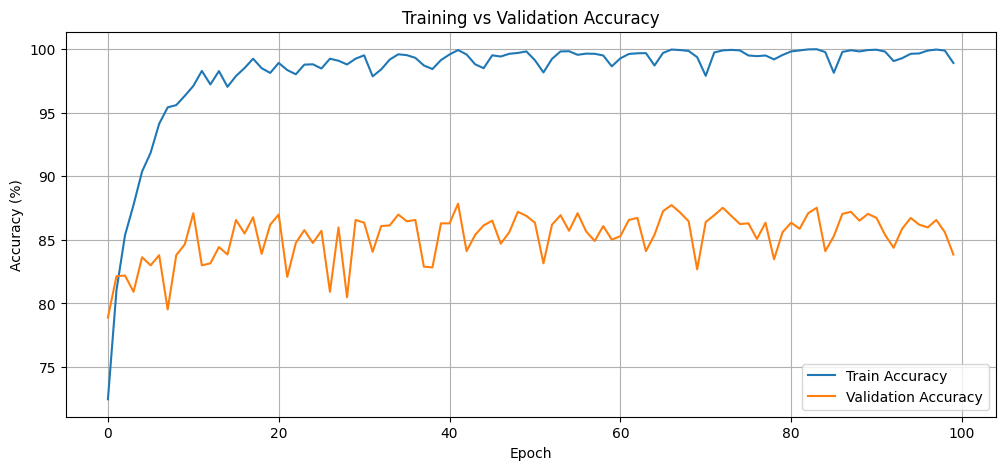

In [62]:
# ==== Accuracy Plot ====
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.title("Training vs Validation Accuracy")
plt.show()

vedere CNN su drive di lomurno e vedere aree delle immagini che si attivano quando fa inference 

## Fine-tuning 
Tutorial: https://github.com/Spandan-Madan/Pytorch_fine_tuning_Tutorial